## 1.Importing Libraries

In [1]:
import sys
import os

import gc
import warnings

from subprocess import check_output


from datetime import datetime
from glob import glob

import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as se

import scipy.stats as stats

from pandas_profiling import ProfileReport


In [2]:
#se.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
#Set pandas view options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
warnings.filterwarnings('ignore')
#%matplotlib inline

## 2.Load Data

In [3]:
raw_data_path = '/Users/Artem_Boltaev/Documents/EPAM Projects/6. RecSys_course/source_code/recsys_course_epam/data/raw/instacart-market-basket-analysis'
print(check_output(["ls", raw_data_path]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [4]:
order_products_train_df = pd.read_csv(raw_data_path + "/order_products__train.csv")
order_products_prior_df = pd.read_csv(raw_data_path + "/order_products__prior.csv")
orders_df = pd.read_csv(raw_data_path + "/orders.csv")
products_df = pd.read_csv(raw_data_path + "/products.csv")
aisles_df = pd.read_csv(raw_data_path + "/aisles.csv")
departments_df = pd.read_csv(raw_data_path + "/departments.csv")
sample_submission_df = pd.read_csv(raw_data_path + "/sample_submission.csv")

1 . aisles.csv - aisles in which the products belong

2 . departments.csv - department in which the products belong

3 . order_products__prior.csv - These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items.

4 . order_products__train.csv - These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items.

5 . orders.csv - This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

6 . products.csv - list of all products

7 . sample_submission.csv - a sample submission file in the correct format

## 3.Basic EDA

In [5]:
aisles_df.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [6]:
aisles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [7]:
aisles_df.nunique()

aisle_id    134
aisle       134
dtype: int64

In [8]:
departments_df.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [9]:
order_products_train_df.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [10]:
order_products_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [11]:
order_products_prior_df.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [12]:
order_products_prior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [13]:
orders_df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [14]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [15]:
products_df.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [16]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [17]:
sample_submission_df.head(10)

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259
5,313,39276 29259
6,353,39276 29259
7,386,39276 29259
8,414,39276 29259
9,418,39276 29259


In [18]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  75000 non-null  int64 
 1   products  75000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [19]:
profile = ProfileReport(aisles_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
profile = ProfileReport(departments_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
profile = ProfileReport(order_products_prior_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
profile = ProfileReport(order_products_train_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
profile = ProfileReport(orders_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
profile = ProfileReport(products_df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
#merge all dataframes into one and make ProfileReport
df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
df = pd.merge(df, aisles_df, on='aisle_id', how='left')
df = pd.merge(df, departments_df, on='department_id', how='left')
df = pd.merge(df, orders_df, on='order_id', how='left')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [26]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
df_train = pd.merge(order_products_train_df, products_df, on='product_id', how='left')
df_train = pd.merge(df_train, aisles_df, on='aisle_id', how='left')
df_train = pd.merge(df_train, departments_df, on='department_id', how='left')
df_train = pd.merge(df_train, orders_df, on='order_id', how='left')
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


In [28]:
profile = ProfileReport(df_train, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## 4.Complex EDA

In [ ]:
#TODO test on distribution shift train and test
#TODO explore data ser with days_since_prior_order = 30 and 0


In [ ]:
#Count of reorders vs percentage of reorder for 20 most reordered items

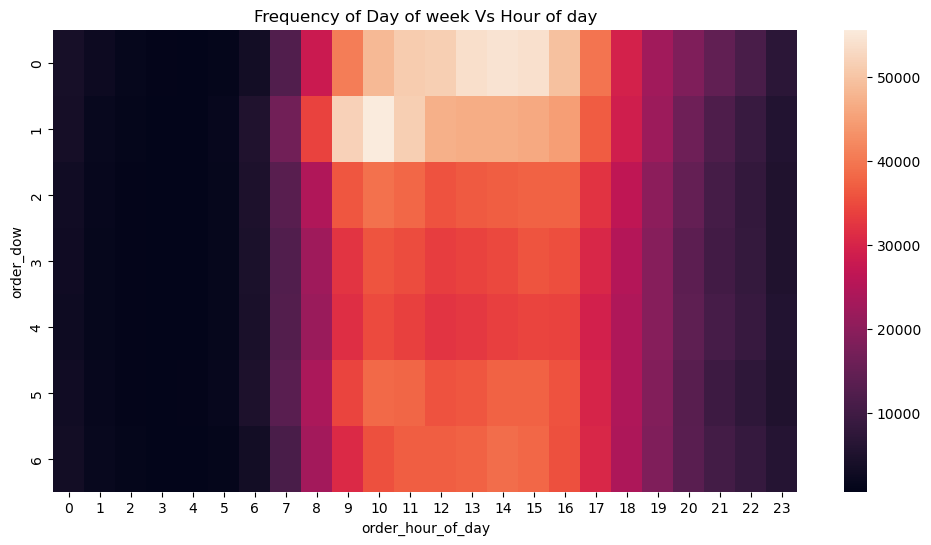

In [27]:
#let us combine the day of week and hour of day to see the distribution
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
se.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

In [30]:
#Situation when none of the products are re-ordered
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [31]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

In [36]:
#most popular products
cnt_srs = df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


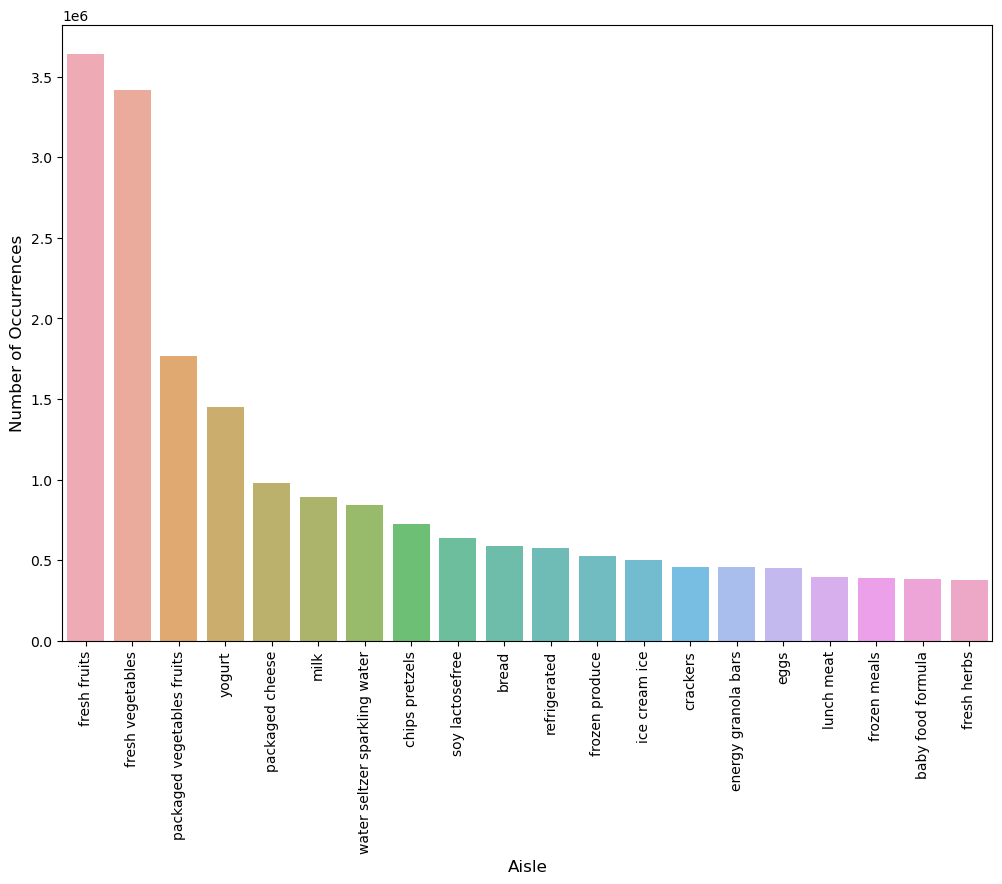

In [38]:
#important aisles
cnt_srs = df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
se.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

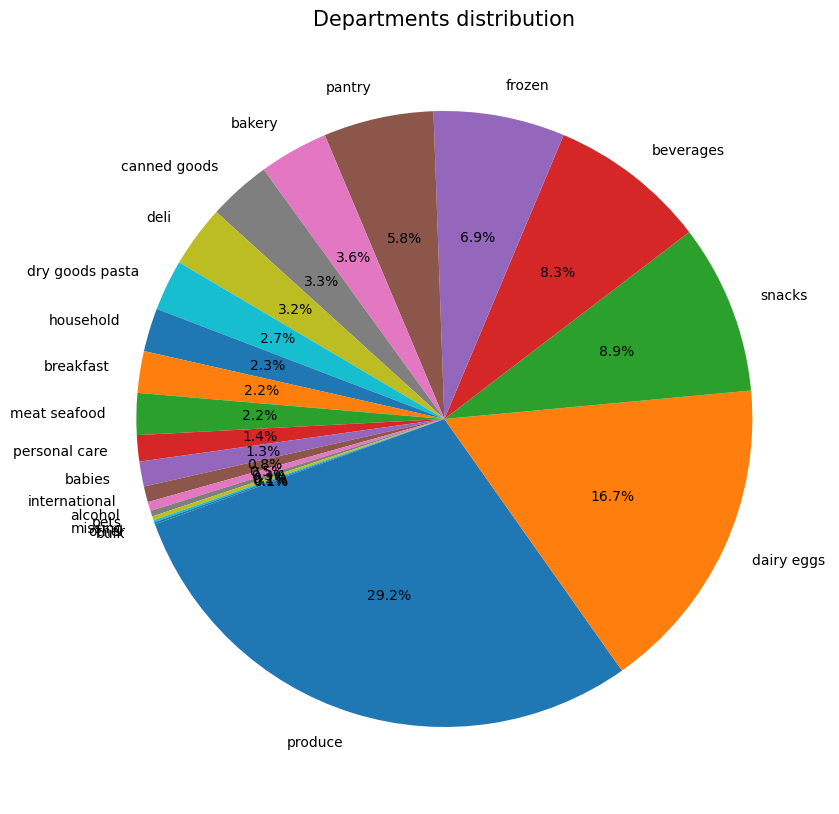

In [39]:
#the department wise distribution
plt.figure(figsize=(10,10))
temp_series = df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

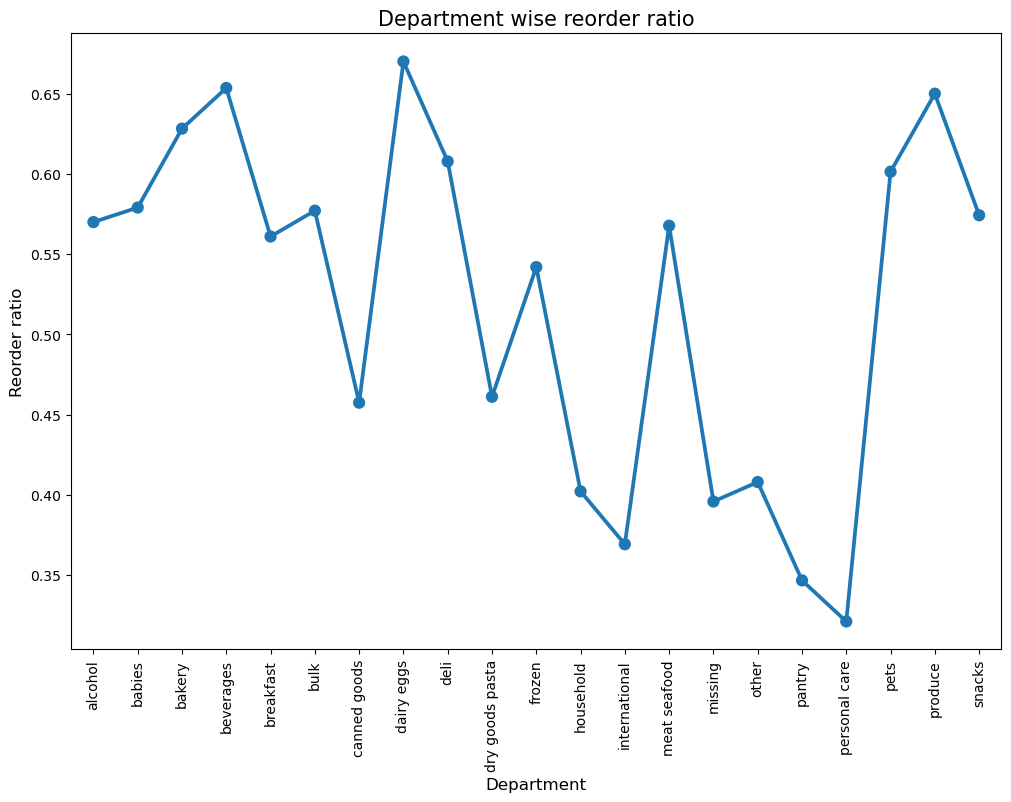

In [41]:
#the reordered percentage of each department
grouped_df = df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
se.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

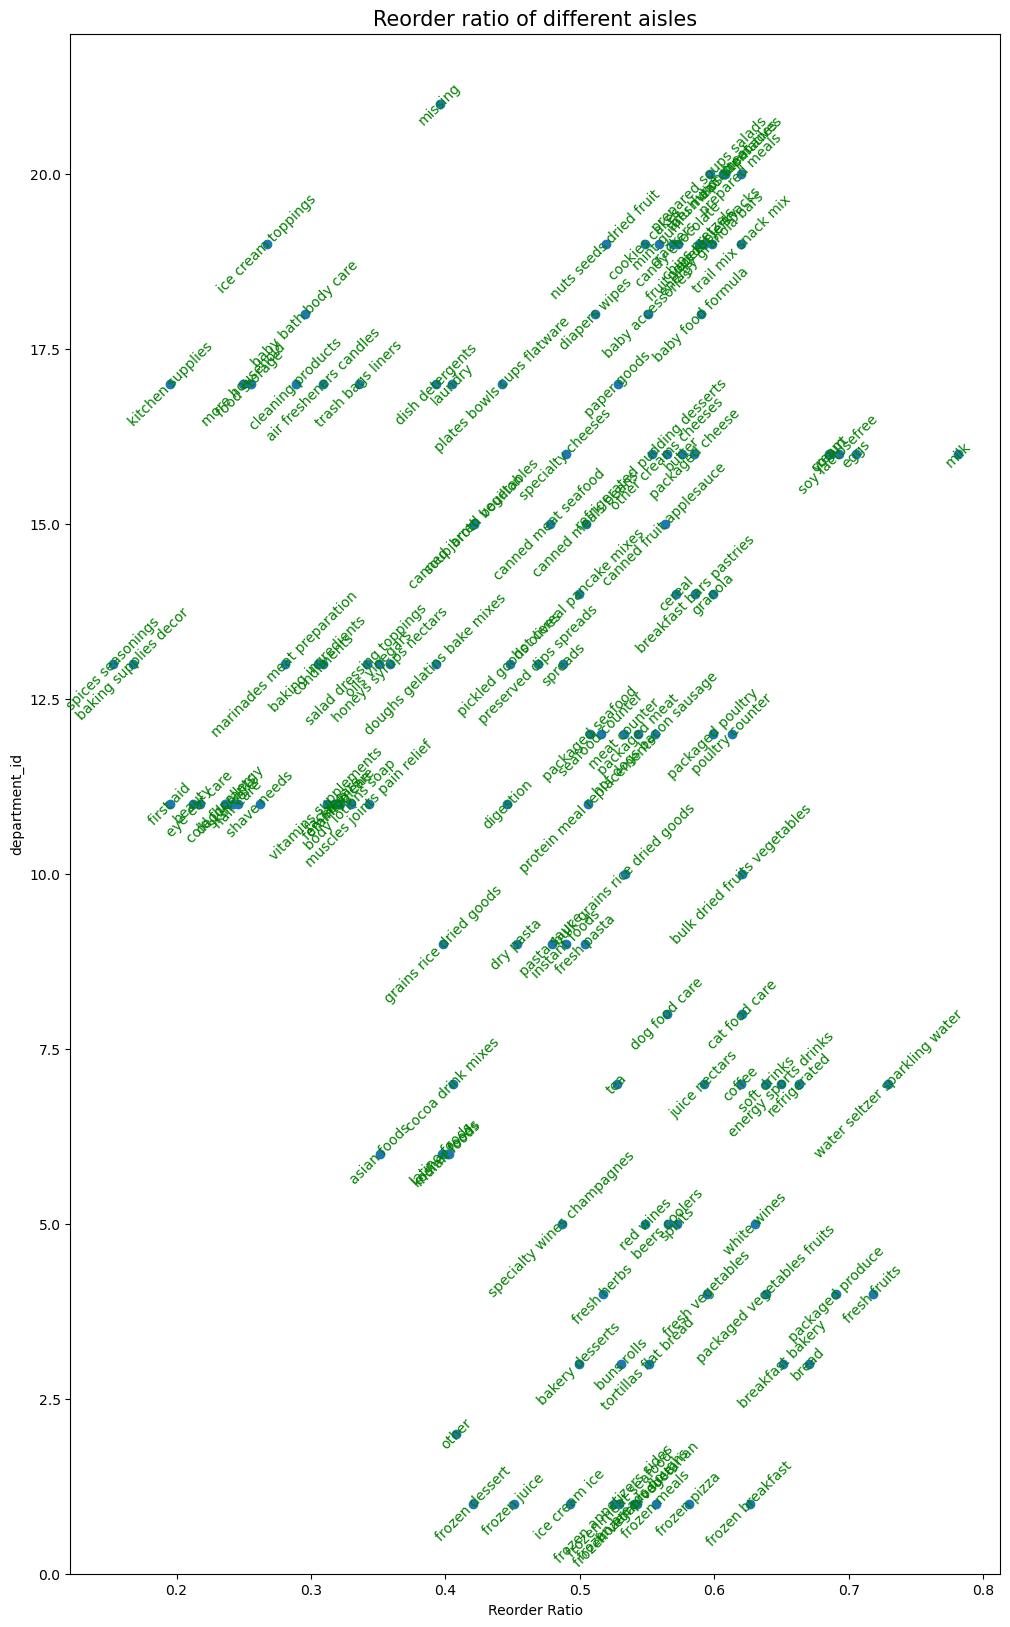

In [42]:
#Aisle - Reorder ratio
grouped_df = df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

In [ ]:
#TODO Visualizing a specific user's history


## 5.Insights and Conclusions

1 . aisles.csv - на первый взгляд все хорошо, 134 уникальных значения, нет пропусков

2 . departments.csv - на первый взгляд все хорошо, 21 уникальных значения, нет пропусков

3 . order_products__prior.csv - на первый взгляд все хорошо, 32434489 уникальных значения, нет пропусков

4 . в 59% случаев происходит изменение положения товара в корзине как в трайне так и в тесте

5 . максимальная корзина имела 145 товаров

6 . есть много товаров часто покупаемых - проверить на дамми продукты

7 . orders.csv - days_since_prior_order has 206209 (6.0%) missing values

8 . orders.csv - days_since_prior_order has 67755 (2.0%) zeros

9 . 206209 unique users; 49688 unique products

10 . для некоторых пользователей скорее всего обрезали колличество заказов до 100 в рассматриваемый промежуток времени что тоже является пропуском в данных

11 . 0 и 1 скорее всего суббота и воскресенье - проверить. В эти дни покупают на процентов 10 больше товаров чем в остальные дни.

12 . Больше всего товаров покупают с 9 до 16 часов

13 . Распределение по дням с последней покупки необычное - есть пики в 7 и 30 дней. Возможно это связано с тем что люди покупают еженедельно или ежемесячно. Хотя странно что люди покупают раз в месяц. Наибольшие значениям между 2 и 8 днями, потом идет спад.

14 . Есть небольшая корреляция между days_since_prior_order и order_number

15 . aisle_id is highly correlated with department_id

16 . есть департамент с очень малым колличеством товаров - только 38

17 . Satuday evenings and Sunday mornings are the prime time for orders

18 . About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%.

19 . Most of popular items are organic products. Also majority of them are fruits.

20 . The top two aisles are fresh fruits and fresh vegetables.

21 . Produce is the largest department

22 . Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

23 . the products that are added to the cart initially are more likely to be reordered again compared to the ones added later

24 . 

